## 1. Load the experiment data  using load_svmlight_file function in sklearn library.

In [1]:
%matplotlib inline 
from sklearn.externals.joblib import Memory  
from sklearn.datasets import load_svmlight_file 
import numpy as np
mem = Memory("./mycache")
@mem.cache

def get_data():
    data = load_svmlight_file("C:\\Users\\Administrator\\Desktop\\机器学习\\lab1\\housing_scale.txt")
    return data[0],data[1]

data_x,data_y = get_data() #Step1:Load the experiment data

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-Administrator-__ipython-input__.get_data...
get_data()
_________________________________________________________get_data - 0.0s, 0.0min


## 2.Divide dataset into training set and validation set using train_test_split function.

In [2]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(data_x,data_y,test_size=0.33,random_state=42) 
#Step2:divide dataset into training set and validation set 

y_train = np.mat(y_train).T #shape y_train to m_train*1
y_valid = np.mat(y_valid).T #shape y_valid to m_valid*1

## 3.Initialize linear model parameters randomly.

In [3]:
w = np.mat(np.random.random([14,1]))*2-1 #Step3:Initialize linear model parameters randomly range(-1,1).

## 4.Choose loss function and derivation.

In [4]:
#Step4:Choose loss function and derivation.

 $$ L_D（w） = \frac{1}{2m}(y -Xw)^T (y -Xw) $$

$$ \frac{\partial L_D（w）}{\partial w}=\frac{1}{m}(-X^Ty+X^T Xw) $$

## 5.Linear Regression and Gradient Descent.

Best Loss_valid: 12.6323815269


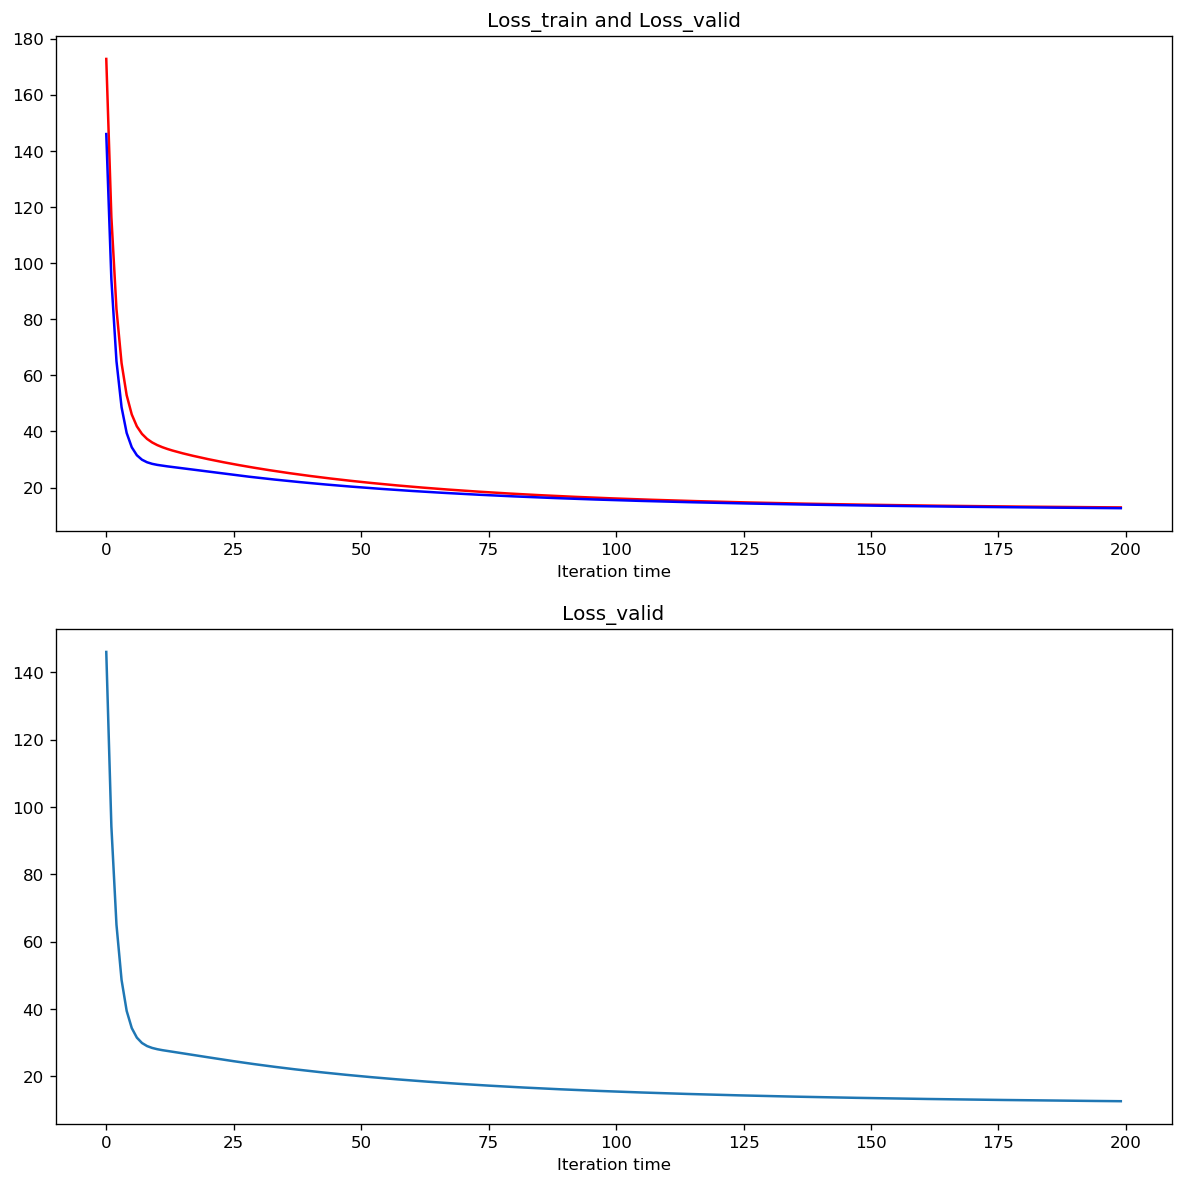

In [5]:
from scipy import sparse 
import matplotlib.pyplot as plt

m_train = x_train.shape[0] #number of training example
m_valid = x_valid.shape[0] #number of validation example

x_1_train = np.ones((m_train,1),dtype='float64') #creat [1,1,……,1]^T
X_train = sparse.hstack((x_train,x_1_train)) #merge x_train and [1,1,……,1]^T

x_1_valid = np.ones((x_valid.shape[0],1),dtype='float64') #creat [1,1,……,1]^T
X_valid = sparse.hstack((x_valid,x_1_valid)) #merge x_valid and [1,1,……,1]^T

Loss_train = [] #Loss_train-axis
Loss_valid = [] #Loss_valid-axis
x = [] #x-axis:the number of iterations
best_loss = 100

for n in range(0,200):#Step9:Repeat step5 to step8 for 200 times.
    G = (1/m_train)*((-X_train.T * y_train) + (X_train.T * X_train * w)) 
    #Step5:Calculate gradient G toward loss function from all samples.

    D = -G #Step6:Denote the opposite direction of gradient G as D.

    learn_rate = 0.05 #Learning rate

    w = w + learn_rate*D #Step7:Update model parameters.

    x.append(n) #Update x-axis
    
    if(1/(2*m_valid) * (y_valid-X_valid*w).T * (y_valid-X_valid*w)<best_loss):
        best_loss = 1/(2*m_valid) * (y_valid-X_valid*w).T * (y_valid-X_valid*w)
    
    Loss_train.append( ( 1/(2*m_train) * (y_train-X_train*w).T * (y_train-X_train*w) )[0,0])
    Loss_valid.append( ( 1/(2*m_valid) * (y_valid-X_valid*w).T * (y_valid-X_valid*w) )[0,0])
    #Step8:Get the Loss under training set and validation set.

plt.figure(figsize=(12,12),dpi=120)
f1 = plt.subplot(211)
plt.plot(x, Loss_train,color= 'red')
plt.plot(x, Loss_valid,color = 'blue')
f1.set_xlabel("Iteration time")
f1.set_title("Loss_train and Loss_valid")

f2 = plt.subplot(212)
plt.plot(x, Loss_valid)
f2.set_xlabel("Iteration time")
f2.set_title("Loss_valid")
#Step10:Drawing graph of Loss_train and Loss_valid with the number of iterations.
print("Best Loss_valid: "+str(best_loss[0,0]))
      #the Loss_valid after the last interation